# GPS Code Positioning

Εξίσωση Παρατήρησης Κώδικα:
$$ P_{j, rec}^{sat} = \rho _{rec}^{sat} + c \cdot (\delta t_{rec} - \delta t^{sat}) + \delta T_{j, rec}^{sat} + \delta I_{j, rec}^{sat} + \epsilon_{j,rec}^{sat} $$
με

* $j$ = 1,2,5, συχνότητα κύματος,
* $\rho _{rec}^{sat} = \rho(t) _{rec}^{sat} = \sqrt((x^{sat}-x_{rec})^2+(z^{sat}-z_{rec})^2+(z^{sat}-z_{rec})^2)$,
* $\delta t_{rec}$ το σφάλμα χρονομέτρου του δέκτη,
* $\delta t^{sat}$ το σφάλμα χρονομέτρου του δορυφόρου,
* $\delta T_{j, rec}^{sat}$ σφάλμα (καθυστέρηση) λόγω τροπόσφαιρας,
* $\delta I_{j, rec}^{sat}$ σφάλμα (καθυστέρηση) λόγω ιονόσφαιράς,
* $\epsilon$ εναπομείναντα σφάλματα

Για να απαλείψουμε το σφάλμα της ιονόσφαιρας, θα χρησιμοποιήσουμε τον γραμμικό συνδυασμό P3.

Θα χρειαστούμε:
* ένα (data) RINEX v3.x αρχείο, με τις παρατηρήσεις ενός σταθμού

In [12]:
# set the name of the (GNSS) RINEX file to use
rinex_fn = "../../../data/DYNG00GRC_R_20240010000_01D_30S_MO.rnx"

* ένα sp3[cd] αρχείο, με τροχιές δουρφόρων GPS που να καλύπτει το διάστημα των παρατηρήσεων του αρχείου RINEX

In [13]:
# set the name of the Sp3 file for the same satellite, covering the same day
sp3_fn = "../../../data/COD0MGXFIN_20240010000_01D_05M_ORB.SP3"

* αρχείο μετεωρολογικών δεδομένων gpt3 (Global Pressure Temperature Model)

In [14]:
# gpt35_grid = "../../data/gpt3_5.grd"
#
# https://vmf.geo.tuwien.ac.at/trop_products/GNSS/VMF3/VMF3_OP/yearly/y2024.vmf3_g
#
vmf3_data = "../../../data/y2024.vmf3_g"

#
# http://ftp.aiub.unibe.ch/CODE/2024/
#
dcb_data = "../../../data/COD0MGXFIN_20240010000_01D_01D_OSB.BIA"

#
# https://files.igs.org/pub/station/general/
#
atx_data = "../../../data/igs20.atx"

* τις παρακάτω βιβλιοθήκες της Python

In [15]:
from dsoclasses.orbits.interpolator import Sp3Interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.rinex.gnss.rinex import GnssRinex, fetch, fetchv
from dsoclasses.troposphere.vmf3 import SiteVmf3
from dsoclasses.time.pyattotime import at2pt, fsec2asec
import dsoclasses.gnss.atx as atx
from dsoclasses.gnss.biasx import Bsinex
from dsoclasses.gnss.atx import Atx
import attotime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.spatial.transform import Rotation as nRot

* συναρτήσεις/μεταβλητές που δημιουργήσαμε στο gps_code_analysis.ipynb. Θα υπολογίσουμε επίσης την διόρθωση λόγω σχετικότητας, λόγω της (σχετικήες) ταχύτητας δορυφόρου-δέκτη: $\delta _{rel} = 2 \cdot \frac{\vec{r}\cdot\vec{v}}{c}$

In [16]:
# Γεωμετρική απόσταση δορυφόρου-δέκτη
geometric_range = alg.geometric_range

# Συν/νες δορυφόρου την εποχή εκπομπής
sat_at_emission_time = alg.sat_at_emission_time

# Προσεγγιστικός υπολογισμός ταχύτητας δορυφόρου, από διαδοχικές θέσεις
def sat_vel(t, interpolator, sat, dsec=.5):
    xn1, yn1, zn1, _ = interpolator.sat_at(sat, t+attotime.attotimedelta(milliseconds=dsec*1e3))
    xc, yc, zc, _ = interpolator.sat_at(sat, t)
    xn2, yn2, zn2, _ = interpolator.sat_at(sat, t+attotime.attotimedelta(milliseconds=2*dsec*1e3))
    vel1 = (np.array((xn1, yn1, zn1)) - np.array((xc, yc, zc))) / dsec
    vel2 = (np.array((xn2, yn2, zn2)) - np.array((xc, yc, zc))) / dsec / 2
    return (2*vel1 + 1*vel2) / 3., np.array((xc, yc, zc))

# Διόρθωση σχετικότητας
def relativity(t_reception, dt, interpolator, sat, dsec=.5):
    t_emission = t_reception - fsec2asec(dt)
    vel, pos = sat_vel(t_emission, interpolator, sat, dsec)
    return 2. * np.inner(pos, vel) / gs.C

def sagnac(rsat, rsta):
    return (gs.OmegaEarth / gs.C) * (rsat[0]*rsta[1] - rsat[1]*rsta[0])

Για τον υπολογισμό της τροποσφαιρικής επίδρασης με το μοντέλο GPT/GMF θα χρησιμοποιήσουμε την συνάρτηση: `tropo_delay(rsta, t, el, gpt3_grid)`, όπου το `gpt3_grid` είναι το αρχείο των μετεωρολογικών δεδομένων.

In [17]:
# Παρεμβολή για τις τροχιές
intrp = intrp = Sp3Interpolator.from_sp3(sp3_fn, ['E'], interval_in_sec=1800, min_data_pts=12, itype='Barycentric')
# Αρχικοποίηση του αντικειμένου GnssRinex
rnx = GnssRinex(rinex_fn)
# προσεγγιστικές συν/νες δέκτη (από RINEX)
rsta = np.array(rnx.approx_cartesian())
# Μετατροπή σε ελλειψοειδείς συν/νες (δέκτης)
lat, lon, hgt = transformations.car2ell(*rsta)
# Tropo
vmf = SiteVmf3(vmf3_data, [rnx.marker_name])
# DCB
bsnx = Bsinex(dcb_data)
# Atx
atx = Atx(atx_data)

## Εκτίμηση Συν/νων και Σφάλματος Χρονομέτρου Δέκτη

Οι άγνωστες παράμετροι που θα πρέπει να εκτιμήσουμε είναι:
* $(x, y, z)$ του δέκτη, και
* $\delta t_{rec}$ για κάθε εποχή παρατήρησης

Αντί του $\delta t_{rec}$ για κάθε εποχή παρατήρησης, μπορούμε να χρησιμοποιήσουμε την ποσότητα $c \cdot \delta t_{rec}$.

Η εξίσωση παρατήρησης, για κάθε δορυφόρο ($j$) και κάθε εποχή ($t_i$) είναι:
$$ f_i \equiv PC_{rec}^{j}(t_i) + c \cdot \delta t^{j}(t_i) - \rho _{rec}^{j}(t_i) - c \cdot \delta t_{rec}(t_i) - \delta T_{rec}^{j}(el) = \epsilon_{rec}^{sat}(t_i) $$
με
$\rho _{rec}^{j} = \rho(t) _{rec}^{j} = \sqrt((x^{j}-x_{rec})^2+(z^{j}-z_{rec})^2+(z^{j}-z_{rec})^2)$

Η εξίσωση παρατήρησης είναι μη-γραμμική, συνεπώς θα εκτιμήσουμε τις άγνωστες παραμέτρους (με χρήση της Μεθόδου των Ελαχίστων Τετραγώνων) με επαναλληπτική διαδικασία. Για όλες τις άγνωστες παραμέτρους, χρειαζόμαστε αρχικές τιμές. Για τις (κατεσιανές) συν/νες του δέκτη, θα χρησιμοποιήσουμε τις συν/νες που δίνονται στο RINEX. Για το σφάλμα του ρολογιού, θα ξεκινήσουμε με την τιμή $0$. Άρα:

$\bf{x}_0 = \begin{bmatrix} x_0 & y_0 & z_0 & 0 & 0 & \dots & 0 \end{bmatrix}$

Θα χρειστούμε επίσης τις μερικές παραγώγους ως προς τις άγνωστες παραμέτρους. Θα πρέπει λοιπόν να υπολογίσουμε τον (Ιακωβιανό) πίνακα:
$$ J = \begin{bmatrix} 
\frac{\partial f_1}{\partial x} & \frac{\partial f_1}{\partial y} & \frac{\partial f_1}{\partial z} & 
   \frac{\partial f_1}{\partial (c \delta t_{rec,1})} & \frac{\partial f_1}{\partial (c \delta t_{rec,2})} & \dots &  \frac{\partial f_1}{\partial (c \delta t_{rec,n})}\\
   \frac{\partial f_2}{\partial x} & \frac{\partial f_2}{\partial y} & \frac{\partial f_2}{\partial z} & 
   \frac{\partial f_2}{\partial (c \delta t_{rec,1})} & \frac{\partial f_2}{\partial (c \delta t_{rec,2})} & \dots &  \frac{\partial f_2}{\partial (c \delta t_{rec,n})}\\
   \vdots & \vdots & \vdots & \vdots & \vdots & \dots & \vdots \\
   \frac{\partial f_m}{\partial x} & \frac{\partial f_m}{\partial y} & \frac{\partial f_m}{\partial z} & 
   \frac{\partial f_m}{\partial (c \delta t_{rec,1})} & \frac{\partial f_m}{\partial (c \delta t_{rec,2})} & \dots &  \frac{\partial f_m}{\partial (c \delta t_{rec,n})}\\
\end{bmatrix} $$
Ο Ιακωβιανός, θα υπολογιστεί στις αρχικές τιμές $\bf{x}_0$.

Ο αριθμός των παρατηρήσεων είναι $m$, όσες και οι σειρές του πίνακα $J$. Ο αριθμός των στηλών του $J$ είναι $3 + n$, όπου $n$ οαριθμός των εποχών μετρήσεων. Προφανώς, θα πρέπει να ισχύει $m > n+3$ για να εφαρμόσουμε τα ελάχιστα τετράγωνα.

Τέλος, θα πρέπει να υπολογίσουμε το διάνυσμα των παρατηρούμενων - υπολογισμένων τιμών $\delta l$.

### Βασικές παράμετροι / Επιλογές Ανάλυσης

In [18]:
# Δεν θα χρησιμοποιήσοουμε τον δορυφόρο 27, λόγω πολύ μεγάλων υπολοίπων
EXCLUDE_SATELLITES = []

# Γωνία αποκοπής· θα χρησιμοποιήσουμε μόνο παρατηρήσεις σε γωνία ύψους μεγαλύτερη από αυτή
ELEVATION_CUT_OFF  = np.radians(3)

# Για ευκολία, μπορούμε να χρησιμοποιήσουμε μόνο παρατηρήσεις που απέχουν μεταξύ τους κάποια δευτερόλεπτα. Έτσι, 
# θα έχουμε μικρότερο αριθμό παρατηρήσεων προς επεξεργασία
EVERY_SEC          = 180.

f1 = gs.GAL_E1_FREQ # MHz
f2 = gs.GAL_E5_FREQ # aka E5a MHz
fac = f1*f1 - f2*f2
SAT_SYS = 'E'
FREQ1 = 'E1'
FREQ2 = 'E5a'

### Προ-επεξεργασία και συλλογή δεδομένων

Θα συλλέξουμε από το αρχείο RINEX όλες τις παρατηρήσεις που πληρούν τα κριτήρια που θέσαμε. Θα τις αποθηκεύσουμε, μαζί με βασικές πληροφοίες που θα υπολογίσουμε, ώστε έπειτα να κάνουμε την εκτίμηση των παραμέτρων.

In [20]:
# αριθμός εποχών που θα επεξεργαστούμε
num_epochs = 0
# θα αποθηκεύσουμε τις παρατηρήσεις και τα υπολογισμένα στοιχεία εδώ
raw_obs    = []
# εποχή προηγούμενης παρατήρησης
t_prev = rnx.time_first_obs
# new ZWD every N hours
ZWD_EVERY_HOURS = 2.
def ztk(kidx):
    return rnx.time_first_obs + attotime.attotimedelta(seconds=kidx*ZWD_EVERY_HOURS*3600.)

# handle PCOs 
pco_bias = atx.get_noazi(rnx.antenna_type, {"E": [FREQ1, FREQ2]})
pco_G01_neu = np.array(pco_bias.pco('E', FREQ1))
pco_G02_neu = np.array(pco_bias.pco('E', FREQ2))
pco_IF_neu = (f1*f1 * pco_G01_neu - f2*f2 * pco_G02_neu) / fac

for block in rnx:
    t = block.t()
    # θα χρησιμοποιηθεί η εποχή στην επεξεργασία ?
    epoch_used = False
    # απέχει το block τουλάχιστον EVERY_SEC δευτερόλεπτα από το προηγούμενο ?
    if (t-t_prev).total_seconds() >= EVERY_SEC:
        for sat, obs in block.filter_satellite_system("E", False):
            # περιέχεται ο δορυφόρους στους αποκλεισμένους ?
            if sat not in EXCLUDE_SATELLITES:
                try:
                    p1, ctype1 = fetch(obs, 'C1W', 'C1C', 'C1X')
                    p2, ctype2 = fetch(obs, 'C5X', 'C5I', 'C5Q')
                    cbias1 = bsnx.sat_bias(sat)[ctype1]
                    cbias2 = bsnx.sat_bias(sat)[ctype2]
                    p1 = p1['value'] - cbias1 * 1e-9 * gs.C
                    p2 = p2['value'] - cbias2 * 1e-9 * gs.C

                    # ZWD
                    kidx = int(float((t - rnx.time_first_obs).total_nanoseconds()) / (ZWD_EVERY_HOURS*3600e9))
                    alpha = float((t-ztk(kidx)).total_seconds()) / (ZWD_EVERY_HOURS*3600.)
                    assert ztk(kidx) <= t and ztk(kidx+1) > t

                    #
                    # xsat, ysat, zsat, csat = intrp.sat_at(sat, t)
                    xsat, ysat, zsat, csat, dt_er = sat_at_emission_time(rsta, t, intrp, sat)
                    rsat = np.array([xsat, ysat, zsat])

                    pc = f1*f1*p1/fac - f2*f2*p2/fac
                    r, az, el = transformations.azele(rsat, rsta)

                    # LOS unit vector in NEU
                    uN = np.cos(el) * np.cos(az)
                    uE = np.cos(el) * np.sin(az)
                    uU = np.sin(el)
                    u_neu = np.array([uN, uE, uU])
                    # PCO projection per frequency
                    d_pco1 = np.dot(pco_G01_neu, u_neu)   # [m], L1
                    d_pco2 = np.dot(pco_G02_neu, u_neu)   # [m], L2
                    # PCV in [m]
                    pcv01mm = 1e-3 * pco_bias.pcv_hgt('E', FREQ1, el)
                    pcv02mm = 1e-3 * pco_bias.pcv_hgt('E', FREQ2, el)
                    # Total antenna correction per frequency
                    d_rho1 = d_pco1 + pcv01mm
                    d_rho2 = d_pco2 + pcv02mm
                    # Iono-free antenna correction
                    d_rho_IF = (f1*f1 * d_rho1 - f2*f2 * d_rho2) / fac
                    # Correct P3 to ARP reference
                    pc += d_rho_IF

                    drel = relativity(t, dt_er, intrp, sat, .5)
                    dsagnac = sagnac(rsat, rsta)

                    # γωνία ύψους >= γωνία αποκοπής ?
                    if el >= ELEVATION_CUT_OFF:
                        # dT = vmf.tropo_delay(rnx.marker_name, lat, lon, el, at2pt(t))
                        dT = vmf.vmf3(rnx.marker_name, lat, lon, el, at2pt(t))
                        # αποθηκεύουμε την παρατήρηση
                        candidate = {'t': t, 'p3': pc, 'rsat': rsat, 'csat': csat, 
                                     'el': el, 'dT': dT, 'drel': drel, 'dsagnac': dsagnac,
                                     'cbias1': cbias1, 'cbias2': cbias2,
                                     'zwd_basis': [(kidx, 1.0 - alpha), (kidx+1, alpha)],
                                     'nepoch': num_epochs
                        }
                        # η εποχή θα χρησιμοποιηθεί
                        vals = [candidate['p3'], candidate['csat'], candidate['drel'], candidate['dsagnac']]
                        if np.all(np.isfinite(vals)) and np.all(np.isfinite(candidate['rsat'])):
                            raw_obs.append(candidate)
                            epoch_used = True
                except Exception as e:
                    pass
                    # print(f'Failed collecting obs for sat {sat} at {at2pt(t)} -> {e}')
        if epoch_used:
            # προηγούμενη εποχή παρατήρησης
            t_prev = t
            # αριθμός (μοναδικών) εποχών
            num_epochs += 1
print(f"Number of obsevrations: {len(raw_obs)}")

Number of obsevrations: 3708


### Εφαρμογή Ελαχίστων Τετραγώνων

- Διάνυσμα αρχικών τιμών, $\bf{x}_0$

- Ιακωβιανός: για να τον υπολογίσουμε, χρειαζόμαστε τις μερικές παραγώγους και αρχικές τιμές. $\frac{\partial f_k}{\partial x} = \frac{-(x^{j}-x)}{\sqrt((x^{j}-x)^2+(y^{j}-y)^2+(z^{j}-z)^2)}$ και ομοίως για τα $y$ και $z$. Άρα, $\begin{bmatrix}\frac{\partial f_k}{\partial x} & \frac{\partial f_k}{\partial y} & \frac{\partial f_k}{\partial z} \end{bmatrix} = \frac{1}{\sqrt((x^{j}-x)^2+(y^{j}-y)^2+(z^{j}-z)^2)}\begin{bmatrix}-(x^{j}-x) & -(y^{j}-y) & -(z^{j}-z) \end{bmatrix}$. Τα $\begin{bmatrix}x^{j}&y^{j}&z^{j}\end{bmatrix}$ είναι οι συντεταγμένες του δορυφόρου και $\begin{bmatrix}x&y&z\end{bmatrix}$ οι προσεγγιστικές τιμές.

In [21]:
def gradient(rsat, rrec): 
    r = np.linalg.norm(rsat-rrec)
    return (rrec-rsat) / r

- το διάνυσμα $\delta l$, παρατηρούμενες - υπολογισμένες τιμες, θα το υπολογίσμουμε με βάση τις τιμές που έχουμε αποθηκεύσει.

In [22]:
# Αριθμός παρατηρήσεων
m = len(raw_obs)
print("Number of obsevrations: {:}".format(m))

# handling of zwd params:
num_zwd_params = raw_obs[-1]['zwd_basis'][1][0] + 1
approx_zwd = np.mean([z['dT']['zwd'] for z in raw_obs])

# Αριθμός αγνώστων παραμέτρων
n = 3 + num_epochs + num_zwd_params
print("Number of unknown parameters: {:}".format(n))

x0 = np.concatenate((np.array(rsta), np.zeros(num_epochs), np.array([approx_zwd]*num_zwd_params)))
x = x0.copy()
# m-> number of valid Doppler observations
J = np.zeros((m, len(x0))) # Jacobian matrix (design matrix)
dl = np.zeros(m)           # residual vector (observed - modeled)

sigma0 = 5.                # sigma_0 in [m/sec]
elvs = np.array([obs['el'] for obs in raw_obs]) # elevations arrays
sigma_i = sigma0 / np.sin(elvs)                     # per-observation stdev
sqrt_w = 1. / sigma_i                               # = sqrt(w_i)
W = sqrt_w**2                                       # = 1/sigma_i^2

# αριθμός επαναλλήψεων
LS_ITERATIONS = 3
for ls_iteration in range(LS_ITERATIONS):
    J = np.zeros((m, len(x)))
    dl = np.zeros(m)
    
    # για κάθε παρατήρηση (που έχουμε αποθηκεύσει)
    for i, obs in enumerate(raw_obs):
        # Current parameter estimates
        xsta = x[0:3] # site position estimate
        dtau = x[3+obs['nepoch']] # clock bias * C

        k    = obs['zwd_basis'][0][0]
        kp1  = obs['zwd_basis'][1][0]
        Tk   = x[3+num_epochs+k]
        Tkp1 = x[3+num_epochs+kp1]
        zwd  = obs['zwd_basis'][0][1] * Tk + obs['zwd_basis'][1][1] * Tkp1
        dT   = obs["dT"]["zhd"] * obs["dT"]["mfh"] + zwd * obs["dT"]["mfw"]
        
        observed = obs['p3'] + gs.C * obs['csat']
        computed = geometric_range(obs['rsat'], xsta) + (dT + obs['drel'] + dtau + obs['dsagnac'])
        # παρατήρηση - υπολογισμένη τιμή
        dl[i] = observed - computed
        # σειρά Ιακωβιανού
        J[i, 0:3] = gradient(obs['rsat'], xsta)
        J[i,3+obs['nepoch']] = 1.
        mfw = obs["dT"]["mfw"]
        J[i,3+num_epochs+k]  = mfw * obs['zwd_basis'][0][1]
        J[i,3+num_epochs+kp1]= mfw * obs['zwd_basis'][1][1]

    Jw  = J * sqrt_w[:, None]      # each row scaled by sqrt(w_i)
    dlw = dl * sqrt_w              # same scaling for rhs

    # least squares solution
    dx, *_ = np.linalg.lstsq(Jw, dlw, rcond=None)
    x += dx

    # postfit residuals
    postfit_w = dlw - Jw @ dx
    # convert to unweighted for thresholding
    postfit = np.divide(postfit_w, sqrt_w, out=np.zeros_like(postfit_w), where=sqrt_w!=0)

    # update sigma0_hat and 3σ rejection
    dof = int(np.count_nonzero(sqrt_w)) - len(x)
    dof = max(dof, 1)
    sigma_hat0 = np.sqrt((postfit_w @ postfit_w) / dof)

    # reporting
    print(f'Iteration {ls_iteration} sigma={sigma_hat0:.3f}')

    # standardized residuals: r_i / sigma_i   (sigma_i already per-obs stdev)
    z = np.divide(postfit, sigma_i, out=np.zeros_like(postfit), where=sigma_i>0)

    n_rej = 0
    for i in range(m):
        if sqrt_w[i] > 0 and abs(z[i]) > 3.0:
            sqrt_w[i] = 0.0
            n_rej += 1

    print(f'\tRejected {n_rej} obs with |z|>3')

# de-weight residuals
dl_unweighted = np.divide(dlw, sqrt_w, out=np.zeros_like(dlw), where=sqrt_w!=0)

Number of obsevrations: 3708
Number of unknown parameters: 478
Iteration 0 sigma=0.026
	Rejected 0 obs with |z|>3
Iteration 1 sigma=0.026
	Rejected 0 obs with |z|>3
Iteration 2 sigma=0.026
	Rejected 0 obs with |z|>3


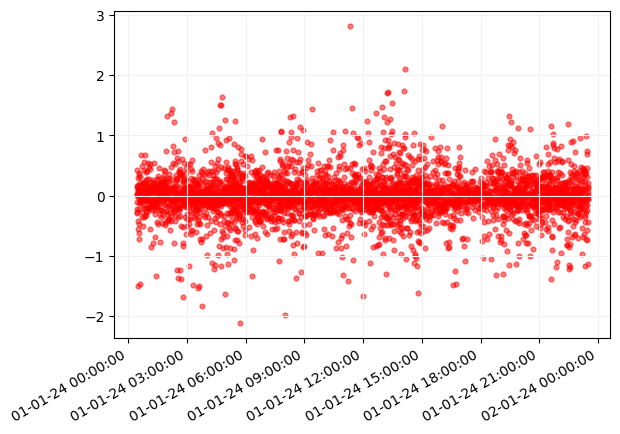

In [23]:
# Γραφική αναπαράσταση - Υπόλοιπα
plt.scatter([at2pt(d['t']) for d in raw_obs], dl_unweighted, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
#plt.ylabel(f"Range-Rate residuals at {site_name} in [m/sec]")
#plt.title(f"Satellite {rnx.sat_name}")
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
# plt.ylim(-.004, .004)
plt.show()

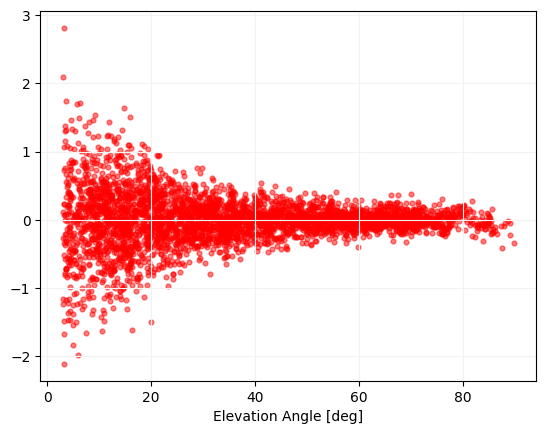

In [24]:
# Γραφική αναπαράσταση - Υπόλοιπα
plt.scatter([np.degrees(d['el']) for d in raw_obs], dl_unweighted, alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
#plt.ylabel(f"Range-Rate residuals at {site_name} in [m/sec]")
plt.xlabel(f"Elevation Angle [deg]")
#plt.title(f"Satellite {rnx.sat_name}")
# plt.ylim(-.006, .006)
plt.show()

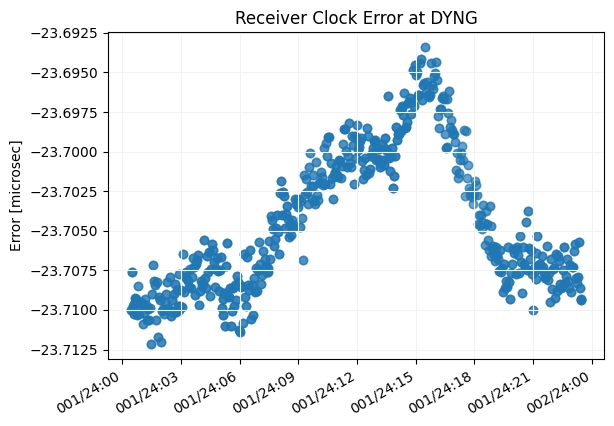

In [25]:
rec_clock_error = [0] * m
for i, obs in enumerate(raw_obs): rec_clock_error[i] = (x[3+obs['nepoch']] / gs.C) * 1e6
fig, ax = plt.subplots()
ax.scatter([at2pt(d['t']) for d in raw_obs], rec_clock_error, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("Error [microsec]")
plt.title("Receiver Clock Error at {:}".format(rnx.marker_name))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

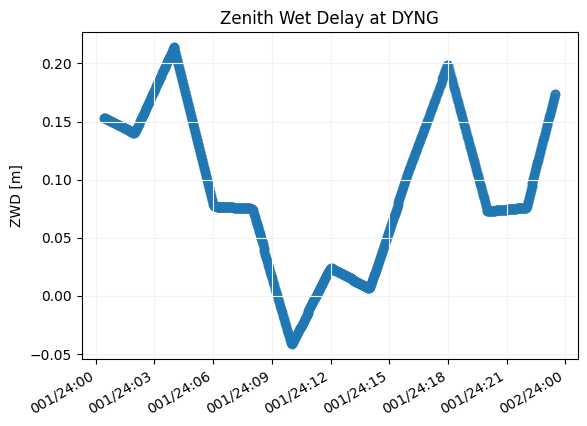

In [26]:
zwd_bias = [0] * m
for i, obs in enumerate(raw_obs):
    k    = obs['zwd_basis'][0][0]
    kp1  = obs['zwd_basis'][1][0]
    Tk   = x[3+num_epochs+k]
    Tkp1 = x[3+num_epochs+kp1]
    zwd_bias[i] = obs['zwd_basis'][0][1]*Tk + obs['zwd_basis'][1][1]*Tkp1
fig, ax = plt.subplots()
ax.scatter([at2pt(d['t']) for d in raw_obs], zwd_bias, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("ZWD [m]")
plt.title(f"Zenith Wet Delay at {rnx.marker_name}")
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

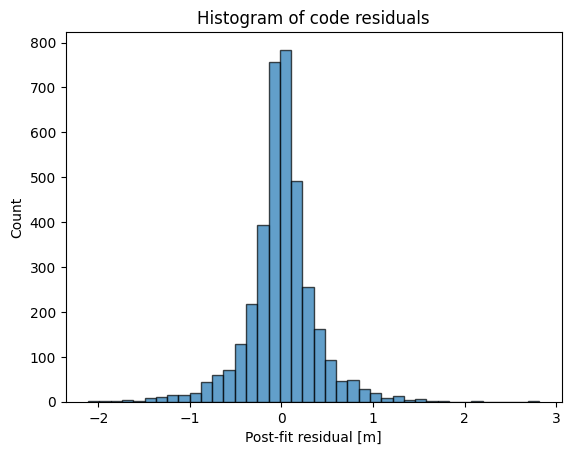

In [27]:
# If we only want residuals from observations that weren't rejected:
mask = sqrt_w > 0      # same weights you used in LS
residuals = dl_unweighted[mask]

fig, ax = plt.subplots()
ax.hist(residuals, bins=40, edgecolor='k', alpha=0.7)

ax.set_xlabel('Post-fit residual [m]')
ax.set_ylabel('Count')
ax.set_title('Histogram of code residuals')

plt.show()